In [30]:
from scipy import signal as ss
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [31]:
frame = pd.DataFrame.from_dict

In [32]:
def sos_table(sos):
    a2 = sos[:,:3][:,2]
    a1 = sos[:,:3][:,1]
    a0 = sos[:,:3][:,0]
    b2 = sos[:,3:][:,2]
    b1 = sos[:,3:][:,1]
    b0 = sos[:,3:][:,0]
    data_sos = {'A2': a2, 'A1': a1, 'A0': a0, 'B2': b2, 'B1': b1, 'B0': b0}
    df_sos = frame(data_sos)
    return df_sos

In [33]:
def plot_s_singularities(zeros, poles):
    plt.subplot(1,2,1)
    x_z = zeros.real
    y_z = zeros.imag
    x_p = poles.real
    y_p = poles.imag
    plt.scatter(x_z, y_z, marker='o', color='blue')
    plt.scatter(x_p, y_p, marker='x',color='red')
    plt.axis('square')
    xl, xr = plt.xlim()
    yu, yb = plt.ylim()
    max_len = abs(xl-xr) if abs(xl-xr)>abs(yu-yb) else abs(yu-yb)
    plt.xlim((-0.9*max_len, max_len*0.1))
    plt.grid()

In [34]:
def plot_z_singularities(zeros, poles):
    plt.subplot(1,2,2)
    x_z = zeros.real
    y_z = zeros.imag
    x_p = poles.real
    y_p = poles.imag
    plt.scatter(x_z, y_z, marker='o', color='blue')
    plt.scatter(x_p, y_p, marker='x',color='red')
    circle1=plt.Circle((0,0),1, fill = False)
    plt.gcf().gca().add_artist(circle1)
    plt.axis('square')
    plt.xlim((-1.1, 1.1))
    plt.ylim((-1.1, 1.1))
    plt.grid()

In [35]:
def plot_mag(filtz, filts):
    wz, hz = ss.freqz_zpk(filtz.zeros, filtz.poles, filtz.gain)
    ws, hs = ss.freqs_zpk(filts.zeros, filts.poles, filts.gain, worN=fs*wz)
    plt.plot(wz/(2*np.pi), 20*np.log10(np.abs(hs).clip(1e-15)), label=r'$|H_a(j \omega)|$')
    plt.plot(wz/(2*np.pi), 20*np.log10(np.abs(hz).clip(1e-15)), label=r'$|H_d(e^{j \omega})|$')
    plt.legend()
    plt.xlabel('Frequency')
    plt.ylabel('Magnitude [dB]')
    plt.grid()

In [36]:
fp = 1000
fa = 1900
fs = 10000
data = {'fp': [fp], 'fa': [fa], 'Ap': [1], 'Aa': [30], 'fs':[fs]}
df = frame(data)
df.head()

,fp,fa,Ap,Aa,fs
0,1000,1900,1,30,10000


## Butterworth

In [37]:
""" Busco el orden del filtro Analógico """
N_b, ws_b = ss.buttord(2*np.pi*fp, 2*np.pi*fa, 1, 30, analog=True)
""" Funcion tranferencia Analógica """
z_b, p_b, k_b = ss.butter(N_b, ws_b, 'low', True, output='zpk')
filt_s_b = ss.lti(z_b, p_b, k_b)

De la aproximacion de Butterworth se obtienen N polos en el semiplano izquierdo del plano s, y tambien se tienen N ceros en el infinito, que los tengo que tener en cuenta al aplicar la tranformacion Bilineal

In [38]:
aux_table = frame({'Polos':p_b, 'Ceros':['inf']*len(p_b)})
aux_table

,Polos,Ceros
0,-1539.808941+6746.343767j,inf
1,-4314.448777+5410.147646j,inf
2,-6234.559120+3002.405432j,inf
3,-6919.838568-0.000000j,inf
4,-6234.559120-3002.405432j,inf
5,-4314.448777-5410.147646j,inf
6,-1539.808941-6746.343767j,inf


Al aplicar la tranformacion bilineal se tiene que $$ s = 2\cdot f_s \cdot \frac{z-1}{z+1} $$ 
Y por lo tanto $$ z = \frac{2f_s + s}{2f_s - s} $$  
Aplicando esta tranformacion a las singularidades obtenidas anteriormente se obtienenen las singularidades para el campo digital. Para las singularidades en el infinito se puede apreciar que corresponden a singularidades en z=-1, por lo tanto de esta transformacion se obtendrán N ceros en z=-1.

In [39]:
pz_b = (2*fs+p_b)/(2*fs-p_b)
zz_b = np.array([-1]*len(pz_b))
aux_table = frame({'Polos':pz_b, 'Ceros':zz_b})
aux_table

,Polos,Ceros
0,0.691133+0.529669j,-1
1,0.567506+0.348782j,-1
2,0.504995+0.172239j,-1
3,0.485893+0.000000j,-1
4,0.504995-0.172239j,-1
5,0.567506-0.348782j,-1
6,0.691133-0.529669j,-1


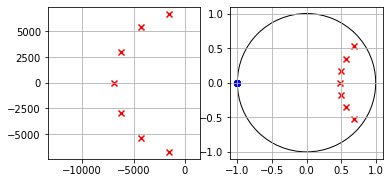

In [40]:
plot_s_singularities(z_b, p_b)
plot_z_singularities(zz_b, pz_b)

En el diagrama de singularidades se puede observar como los ceros que se encontraban en el infinito, en el campo digital se mapean en Z=-1, y los polos que se encontraban en el semiplano izquierdo se encuerntran dentro de la circunferencia de radio 1, manteniendo la estabilidad del sistema.

Al estar todos los ceros en z = -1 para agrupar las singularidades basta tomar el par de polos conjugados, junto con 2 ceros, obteniendose 3 etapas de orden 2, y el polo real corresponde a una etapa de orden 1

In [41]:
a2 = np.array([0,1,1,1])
a1 = np.array([1,2,2,2])
a0 = np.array([1,1,1,1])
a = np.array([a2, a1, a0])

In [42]:
""" Ahora se arman los polinomios de cada par de polos """
"""              Z^2 + 2 Re[polo] Z + |polo|^2         """
""" El polo de primer orden sera 0*Z^2 + Z - polo      """
b2 = np.array([0,1,1,1])
b1 = np.append([1], np.array(-2*pz_b.real[:3]))
b0 = np.append(-pz_b.real[3], np.array(np.abs(pz_b[:3]))**2)
b = np.array([b2, b1, b0])

In [43]:
data_sos = {'A2': a2, 'A1': a1, 'A0': a0, 'B2': b2, 'B1': b1, 'B0': b0}
df_sos = frame(data_sos)
df_sos

,A2,A1,A0,B2,B1,B0
0,0,1,1,0,1.000000,-0.485893
1,1,2,1,1,-1.382265,0.758213
2,1,2,1,1,-1.135012,0.443712
3,1,2,1,1,-1.009989,0.284686


In [44]:
""" Ahora calgulo g para que la ganancia en Z=1 sea 1   """
k_a = np.sum(a[:,0])*np.sum(a[:,1])*np.sum(a[:,2])*np.sum(a[:,3])
k_b = np.sum(b[:,0])*np.sum(b[:,1])*np.sum(b[:,2])*np.sum(b[:,3])
g_b = k_b/k_a

In [45]:
filt_z_b = ss.lti(zz_b, pz_b, g_b)

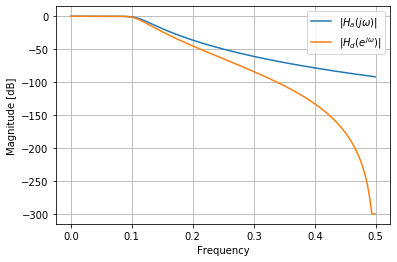

In [46]:
plot_mag(filt_z_b, filt_s_b)

En el grafico de amplitud de puede observar el pre-wrapping, es por ello que la caida en la banda de atenuacion es mayor en el filtro digital 

## Cauer

Sintetizando nuevametne el filtro pero ahora utilizando la aproximacion de Cauer

In [47]:
""" Busco el orden del filtro Analógico """
N_c, ws_c = ss.ellipord(2*np.pi*fp, 2*np.pi*fa, 1, 30, analog=True)

In [48]:
""" Funcion tranferencia Analógica """
z_c, p_c, k_c = ss.ellip(N_c, 1, 30, ws_c, 'low', True, output='zpk')
filt_s_c = ss.lti(z_c, p_c, k_c)

In [49]:
z_c = np.append(np.array(np.inf), z_c)
aux_table = frame({'Polos':p_c, 'Ceros':z_c})
aux_table

,Polos,Ceros
0,-3515.887019+0.000000j,inf+0.000000e+00j
1,-1289.795952-6201.192904j,0.000000e+00+1.227390e+04j
2,-1289.795952+6201.192904j,0.000000e+00-1.227390e+04j


In [50]:
""" Aplico la tranformacion bilineal a las Singularidades """
pz_c = (2*fs+p_c)/(2*fs-p_c)
zz_c = np.append([-1], (2*fs+z_c[1:])/(2*fs-z_c[1:]))
aux_table = frame({'Polos':pz_c, 'Ceros':zz_c})
aux_table

,Polos,Ceros
0,0.700978+0.000000j,-1.000000+0.000000j
1,0.731898-0.504459j,0.452832+0.891596j
2,0.731898+0.504459j,0.452832-0.891596j


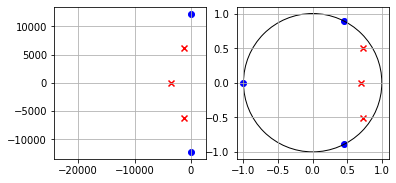

In [51]:
plot_s_singularities(z_c, p_c)
plot_z_singularities(zz_c, pz_c)

Para agrupar las singularidades se toma al par de polos conjugados juntos con el par de ceros conjugados ya que son los que se encuentran mas cercanos, y luego el polo real junto con el cero real forman la etapa de primer orden.

In [52]:
""" Armo las 2 etapas """
a2_c = np.array([0,1])
a1_c = np.append([1], np.array(-2*zz_c.real[1]))
a0_c = np.append(-zz_c.real[0], np.array(np.abs(zz_c[1]))**2)
a_c = np.array([a2_c, a1_c, a0_c])

In [53]:
b2_c = np.array([0,1])
b1_c = np.append([1], np.array(-2*pz_c.real[1]))
b0_c = np.append(-pz_c.real[0], np.array(np.abs(pz_c[1]))**2)
b_c = np.array([b2_c, b1_c, b0_c])

In [54]:
data_sos_c = {'A2': a2_c, 'A1': a1_c, 'A0': a0_c, 'B2': b2_c, 'B1': b1_c, 'B0': b0_c}
df_sos_c = frame(data_sos_c)
df_sos_c

,A2,A1,A0,B2,B1,B0
0,0,1.000000,1.0,0,1.000000,-0.700978
1,1,-0.905664,1.0,1,-1.463796,0.790153


In [55]:
""" Ahora calgulo g para que la ganancia en Z=1 sea 1   """
k_a_c = np.sum(a_c[:,0])*np.sum(a_c[:,1])
k_b_c = np.sum(b_c[:,0])*np.sum(b_c[:,1])
g_c = k_b_c/k_a_c

In [56]:
filt_z_c = ss.lti(zz_c, pz_c, g_c)

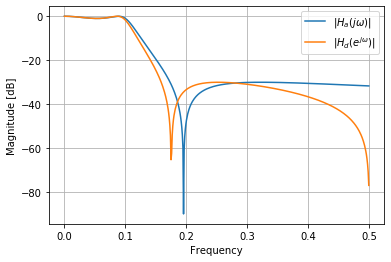

In [57]:
plot_mag(filt_z_c, filt_s_c)

De esta forma se obtiene el filtro con las mismas especificaciones de la plantilla pero utilizando la aproximacion de Cauer. Se puede observar el efecto del pre-wrapping en el grafico de amplitud, por lo cual se genera la caida de la amplitud en la frecuencia $\frac{f_s}{2}$. Tambien se puede observar que la frecuencia del cero de transmision se vio modificada.